In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import pandas as pd
from scipy import linalg

from scipy.sparse import dia_matrix, coo_matrix
from scipy.sparse.linalg import eigs

from cmath import sqrt

# from time import sleep
import time
from IPython.display import clear_output

from mpl_toolkits.mplot3d import Axes3D

### A

In [2]:
def gen_in_shape(N, padding, L, rectangle, circle):
    """
    Generates a 2D array filled with bools that tell if cell is in shape
    """
    
    # Construct 2D array with booleans of whether cell in shape
    in_shape = np.full((N+2*padding,N+2*padding), True)
    
    if not circle and not rectangle:
        # Put padding on False
        for j in range(N+2*padding):
            for i in range(N+2*padding):
                if j==0 or j==N+2*padding-1:
                    in_shape[j,i] = False
                if i==0 or i==N+2*padding-1:
                    in_shape[j,i] = False
        
    elif circle:
        center = int(N/2)+padding
        
        for j in range(0, N+2*padding):
            for i in range(0, N+2*padding):
                dist = np.sqrt((i-center)**2+(j-center)**2)
                if dist > int(N/2):
                    in_shape[j,i] = False
                
    elif rectangle:
        # Put padding on False
        in_shape = np.full((2*N+2*padding, N+2*padding), True)
        for j in range(2*N+2*padding):
            for i in range(N+2*padding):
                if j==0 or j==2*N+2*padding-1:
                    in_shape[j,i] = False
                if i==0 or i==N+2*padding-1:
                    in_shape[j,i] = False

    return in_shape

[[-16.   4.   4.   0.]
 [  4. -16.   0.   4.]
 [  4.   0. -16.   4.]
 [  0.   4.   4. -16.]]


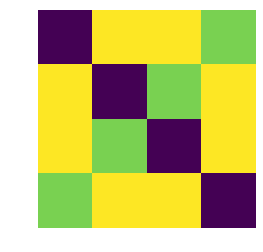

In [75]:
def gen_matrix(N, L=1, radius=0.5, padding=1, rectangle=False, circle=False):
    """
    [3.1A] Generate matrix version
    """
    in_shape = gen_in_shape(N, padding, L, rectangle, circle)
    
    dx = L/N
    
    # Set up M matrix and b vector
    M = np.zeros((N**2, N**2))
#     b = np.zeros(N**2)
    
    height_shape = N 
    if rectangle:
        M = np.zeros(((2*N**2, 2*N**2)))
        b = np.zeros(2*N**2)
        height_shape = 2*N
    
    cellcount = 0
    for j in range(height_shape):
        for i in range(N):
    
            M[cellcount, cellcount] = -4
    
            # Iterate over neighbors:
            if in_shape[j-1+padding, i+padding]:
                M[cellcount, cellcount-N] = 1
                    
            if in_shape[j+1+padding, i+padding]:
                if cellcount+N+padding < len(M[cellcount])+1:
                    M[cellcount, cellcount+N] = 1
                    
            if in_shape[j+padding, i+1+padding]:
                M[cellcount, cellcount+1] = 1  
                    
            if in_shape[j+padding, i-1+padding]:
                M[cellcount, cellcount-1] = 1
                
            cellcount += 1
    
    return M*(1/dx**2)

N = 2
M = gen_matrix(N, L=1, circle=False)
print(M)
plt.imshow(M)
plt.axis('off')
plt.savefig('Matrix_example.pdf', bbox_inches='tight')
plt.show()

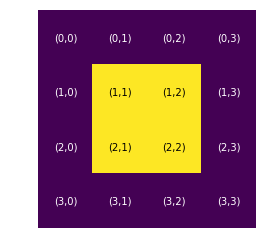

In [4]:
grid = np.zeros((4,4))

in_object = ((1,1), (1,2), (2,1), (2,2))

for j in range(4):
    for i in range(4):
        if (j,i) in in_object:
            grid[j,i] = 1
            plt.text(j,i,f'({i},{j})', ha="center", va="center")
        else:
            plt.text(j,i,f'({i},{j})', ha="center", va="center", color='w') 

plt.imshow(grid)
plt.axis('off')
# plt.savefig('grid.pdf', bbox_inches='tight')
plt.show()

### B

In [9]:
N = 101
K=-1
L=1

M_sq = gen_matrix(N, L=1)
eigenval_sq = eigs(coo_matrix(M_sq), which='SM')

M_ci = gen_matrix(N, L=1, circle=True)
eigenval_ci = eigs(coo_matrix(M_ci), which='SM')

M_rt = gen_matrix(N, L=1, rectangle=True)
eigenval_rt = eigs(coo_matrix(M_rt), which='SM')

c:\users\juliu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.


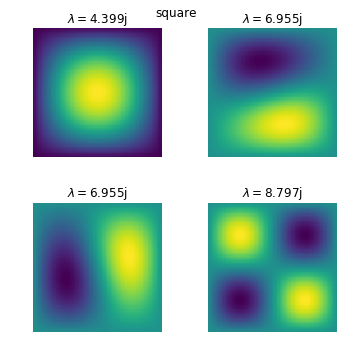

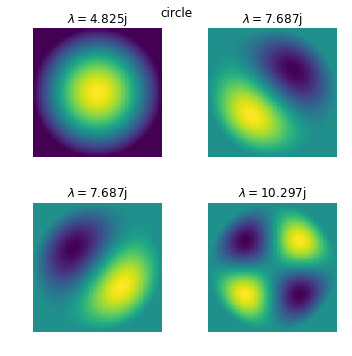

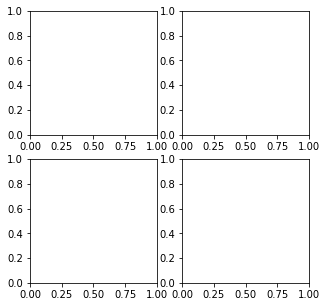

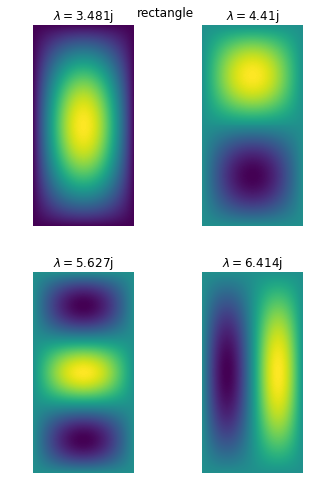

In [10]:
def plot_eigenvec_to_grid(eigen, N, name, rectangle=False):
    eigenval = eigen[0]
    eigenvec = eigen[1].T
    
    # Get the smallest eigenvalues
    small_eigenvals = [sorted([e for e in eigenval if e < 0])[::-1][i] for i in range(4)]
    
    small_eigenvecs = [eigenvec[np.where(eigenval==i)] for i in small_eigenvals]
    
    
    fig, axes = plt.subplots(2,2,figsize=(5,5))
    if rectangle:
        fig, axes = plt.subplots(2,2,figsize=(5,7))  
    
    fig.suptitle(name)
    
    for i,plot in enumerate([(0,0), (0,1), (1,0), (1,1)]):
        y = []
        if not rectangle:
            y = np.real(np.reshape(small_eigenvecs[i], (N,N)))
        else:
            y = np.real(np.reshape(small_eigenvecs[i], (2*N,N)))
            
        T = np.array([[comp_T(t, small_eigenvals[i]) for j in range(y.shape[1])] 
                       for t in range(y.shape[0])])
        
        axes[plot[0], plot[1]].imshow(y)
        axes[plot[0], plot[1]].axis('off')
        axes[plot[0], plot[1]].set_title('$\lambda= $'+str(round(np.sqrt(small_eigenvals[i]),3)))
    
    plt.tight_layout()
#     if name=='rectangle':
#         plt.subplots_adjust(hspace=-0.5)
#     plt.savefig(f'{name}_eigenfreq.pdf', bbox_inches='tight')
    plt.show()

plot_eigenvec_to_grid(eigenval_sq, N, 'square')

plot_eigenvec_to_grid(eigenval_ci, N, 'circle')

plot_eigenvec_to_grid(eigenval_rt, N, 'rectangle', rectangle=True)

In [51]:
all_L = np.arange(1,12)
all_max = []
all_min = []
all_eigenval = []

N = 101

for L in all_L:
    M_sq = gen_matrix(N, L=L)
    eigenval_sq = eigs(coo_matrix(M_sq), k=N-1, which='SM')
    
    all_eigenval += [np.sqrt(-1*eigenval_sq[0])]
    all_max += [max(np.sqrt(-1*eigenval_sq[0]))]
    all_min += [min(np.sqrt(-1*eigenval_sq[0]))]

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


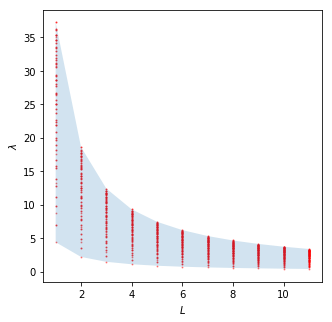

In [56]:
fig = plt.subplots(figsize=(5,5))
for i,L in enumerate(all_L):
    print(all_eigenval[i].shape)
    plt.scatter([L for i in range(N-1)], all_eigenval[i], color='red', 
                s=1, alpha=0.4)
plt.fill_between(all_L, all_max, all_min, alpha=0.2)
plt.xlabel('$L$')
plt.ylabel('$\lambda$')
plt.savefig('eigenfreq_spectrum.pdf', bbox_inches='tight')
plt.show()

In [63]:
per_shape = {'square':[], 'circle':[], 'rectangle':[]}

all_L = np.arange(1,11,2)

N = 101

for name in ['square', 'circle','rectangle']:
    
    all_max = []
    all_min = []
    all_eigenval = []

    for L in all_L:
        
        M = gen_matrix(N, L=L)
        if name == 'circle':
            M = gen_matrix(N, L=L, circle=True)
        elif name=='rectangle':
            M = gen_matrix(N, L=L, rectangle=True)
            
        eigenval = eigs(coo_matrix(M), k=N-1, which='SM')

        all_eigenval += [np.sqrt(-1*eigenval[0])]
        all_max += [max(np.sqrt(-1*eigenval[0]))]
        all_min += [min(np.sqrt(-1*eigenval[0]))]
        
    per_shape[name] = [all_eigenval, all_max, all_min]

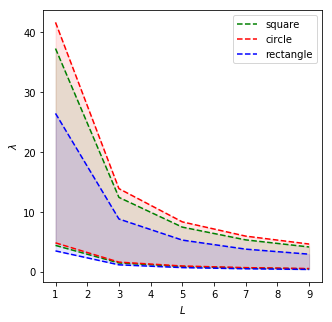

In [68]:
colors = ['green', 'red', 'blue']

fig = plt.subplots(figsize=(5,5))
for j,name in enumerate(['square','circle','rectangle']):
    all_max = per_shape[name][1]
    all_min = per_shape[name][2]
    
#     print(all_max)
#     print(all_min)
#     for i,L in enumerate(all_L):
# #         plt.scatter([L for i in range(N-1)], all_eigenval[i], color=colors[j], 
# #                     s=1, alpha=0.4)
    plt.plot(all_L, all_max, color=colors[j], linestyle='--', label=name)
    plt.plot(all_L, all_min, color=colors[j], linestyle='--')
    plt.fill_between(all_L, all_max, all_min, alpha=0.1, color=colors[j])
    
plt.xlabel('$L$')
plt.ylabel('$\lambda$')
plt.legend()
plt.savefig('allshapes_eigenfreq_spectrum.pdf', bbox_inches='tight')
plt.show()

In [54]:
all_N = np.arange(5,103,6)
all_max_N = []
all_min_N = []
all_eigenval_N = []

L = 1

for N in all_N:
    M_sq = gen_matrix(N, L=L)
    eigenval_sq = eigs(coo_matrix(M_sq), k=N-1, which='SM')
    
    all_eigenval_N += [np.sqrt(-1*eigenval_sq[0])]
    all_max_N += [max(np.sqrt(-1*eigenval_sq[0]))]
    all_min_N += [min(np.sqrt(-1*eigenval_sq[0]))]

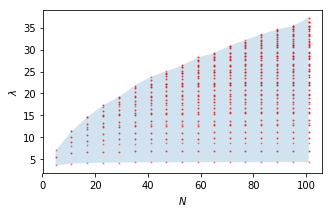

In [55]:
fig = plt.subplots(figsize=(5,3))
for i,N in enumerate(all_N):
#     plt.scatter([N for i in range(len(all_N))], all_eigenval_N[i], color='red', 
#                 s=1, alpha=0.4)
    for j in all_eigenval_N[i]:
        plt.scatter(N, j, color='red', s=1, alpha=0.4)
        
plt.fill_between(all_N, all_max_N, all_min_N, alpha=0.2)
plt.xlabel('$N$')
plt.ylabel('$\lambda$')
plt.savefig('eigenfreq_spectrum_N.pdf', bbox_inches='tight')
plt.show()

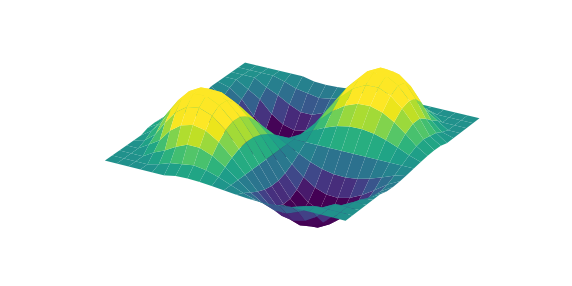

In [74]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def comp_T(t, eigenfreq, A=1, B=1, c=1):
    return np.real(A*np.cos(c*eigenfreq*t) + B*np.sin(c*eigenfreq*t))

def animate(name, N, timesteps, no_eigenfreq=3, L=1, rectangle=False, circle=False, show_animation=False):

    M = gen_matrix(N, L=L, circle=circle, rectangle=rectangle)
    eigenval_res = eigs(coo_matrix(M), k=20, which='SM')
    
    eigenval = eigenval_res[0]
    eigenvec = eigenval_res[1].T
    
#     print(eigenval.shape)
#     print(eigenvec.shape)
    
    # Get the smallest eigenvalues
    small_eigenvals = [sorted([e for e in eigenval if e < 0])[::-1][i] for i in range(20)]
    v0 = np.real([eigenvec[np.where(eigenval==i)] for i in small_eigenvals][no_eigenfreq])
                 
    if not rectangle:
        v0 = v0.reshape((N,N))
    if rectangle:
        v0 = v0.reshape((2*N,N))
    eigenfreq = np.sqrt(-1*small_eigenvals[0])

    all_U = [v0*comp_T(0, eigenfreq)]

    X = np.array([[i for j in range(N)] for i in range(N)])
    Y = np.array([np.arange(0, N) for i in range(N)])
    
    if rectangle:
        X = np.array([[i for j in range(N)] for i in range(2*N)])
        Y = np.array([np.arange(0, N) for i in range(2*N)])

    if show_animation:
        fig = plt.figure(figsize=(10,5))
        ax = plt.axes(projection='3d')

        ax.plot_surface(X, Y, all_U[-1] ,cmap='viridis', edgecolor='none')
        ax.set_zlim(zmin=-0.1, zmax=0.1)
        plt.show()
    
    for t in np.arange(0,timesteps,0.05):
        
        T = comp_T(t, eigenfreq)
        all_U += [v0*T]
        
        if show_animation:
            clear_output(wait=True)

            fig = plt.figure(figsize=(10,5))
            ax = plt.axes(projection='3d')
            ax.set_zlim(zmin=-0.1, zmax=0.1)
            ax.plot_surface(X, Y, all_U[-1] ,cmap='viridis', edgecolor='none', vmin=-0.1, vmax=0.1)
            ax.view_init(elev=60.)
            ax.axis('off')
            plt.show()
        
    return all_U

N = 21
timesteps = 100
all_U = animate('square', N, timesteps, show_animation=True, circle=True, rectangle=False)

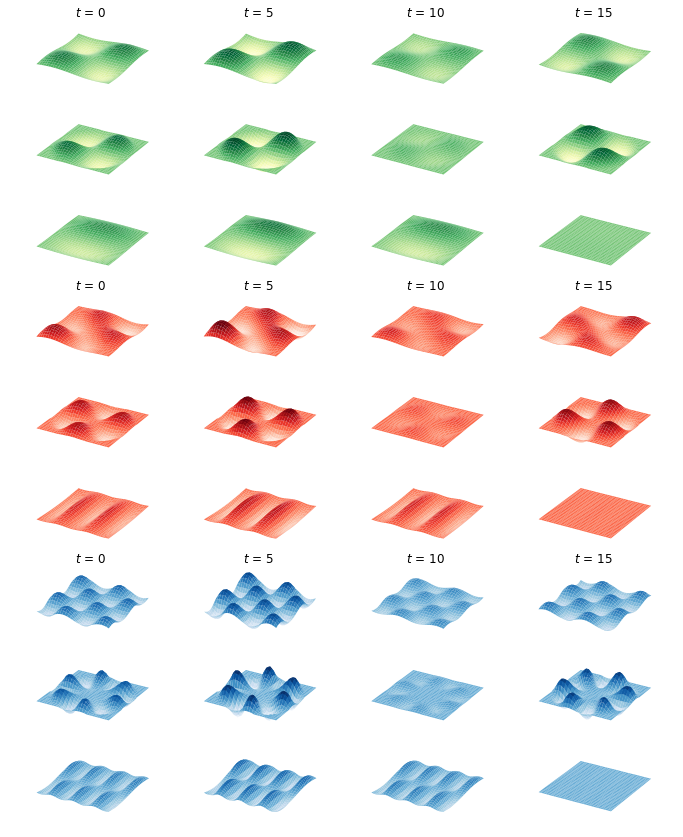

In [49]:
fig = plt.figure(figsize=(12,20))
gs = fig.add_gridspec(12,4)
gs.update(wspace=0.0, hspace=0.052)

all_no_eigenfreq = [3, 7, 19]
colors = ['YlGn', 'Reds', 'Blues']

N = 31
pad = 5

for c,no_eigenfreq in enumerate(all_no_eigenfreq):
    
    timesteps = 20

    all_U_sq = animate('square', N, timesteps, no_eigenfreq=no_eigenfreq, circle=False, rectangle=False)
    all_U_ci = animate('square', N, timesteps,  no_eigenfreq=no_eigenfreq, circle=True, rectangle=False)
    all_U_rc = animate('square', N, timesteps,  no_eigenfreq=no_eigenfreq, circle=False, rectangle=True)

    all_U = all_U_sq, all_U_ci, all_U_rc

#     names = ['Square', 'Circle', 'Rectangle']
    
    rectangle = False

    for row in range(3):
        U = np.array(all_U[row])
        for col in range(4):

            if row==2:
                rectangle=True
            ax = fig.add_subplot(gs[row+3*c,col], projection='3d')

            X = np.array([[i for j in range(N)] for i in range(N)])
            Y = np.array([np.arange(0, N) for i in range(N)])

            if rectangle:
                X = np.array([[i for j in range(N)] for i in range(2*N)])
                Y = np.array([np.arange(0, N) for i in range(2*N)])

            ax.set_zlim(zmin=-0.1, zmax=0.1)
            ax.plot_surface(X, Y, U[int(5*col)] ,cmap=colors[c], 
                            edgecolor='none', vmin=-0.1, vmax=0.1)
            if row==0:
                ax.set_title(f'$t$ = {int(5*col)}')
            ax.view_init(elev=60.)
            ax.axis('off')
    # plt.tight_layout()
plt.savefig('freq_through_time_BIG.pdf', bbox_inches='tight')
plt.show()

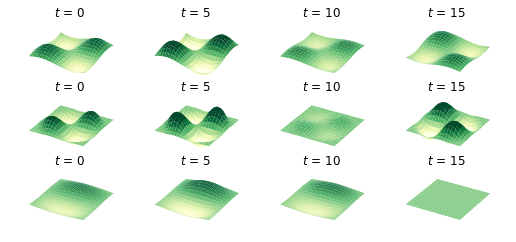

In [220]:
fig = plt.figure(figsize=(9,4))
gs = fig.add_gridspec(3,4)
gs.update(wspace=0.0, hspace=0.052)

# all_U_sq = animate('square', N, timesteps, circle=False, rectangle=False)
# all_U_ci = animate('square', N, timesteps, circle=True, rectangle=False)
# all_U_rc = animate('square', N, timesteps, circle=False, rectangle=True)

# all_U = all_U_sq, all_U_ci, all_U_rc

names = ['Square', 'Circle', 'Rectangle']

# print(all_U)
rectangle = False

for row in range(3):
    U = np.array(all_U[row])
    for col in range(4):

        if row==2:
            rectangle=True
        ax = fig.add_subplot(gs[row,col], projection='3d')
        
        X = np.array([[i for j in range(N)] for i in range(N)])
        Y = np.array([np.arange(0, N) for i in range(N)])

        if rectangle:
            X = np.array([[i for j in range(N)] for i in range(2*N)])
            Y = np.array([np.arange(0, N) for i in range(2*N)])
        
        ax.set_zlim(zmin=-0.1, zmax=0.1)
        ax.plot_surface(X, Y, U[int(5*col)] ,cmap='YlGn', 
                        edgecolor='none', vmin=-0.1, vmax=0.1)
        ax.set_title(f'$t$ = {int(5*col)}')
        ax.view_init(elev=60.)
        ax.axis('off')
# plt.tight_layout()
# plt.savefig('freq_through_time.pdf', bbox_inches='tight')
plt.show()

In [117]:
all_N = np.arange(3,101,8)

times_nosparse = []
times_sparse   = []

for N in all_N:
    M_sq = gen_matrix(N, L=1)
    
    begin_nosparse = time.time()
    eigenval_sq = linalg.eig(M_sq)
    end_nosparse = time.time()
    times_nosparse += [(end_nosparse-begin_nosparse)/N]
    
    begin_sparse = time.time()
    eigenval_sq = eigs(coo_matrix(M_sq), k=N-1, which='SM')
    end_sparse = time.time()
    times_sparse += [(end_sparse-begin_sparse)/(N-1)]

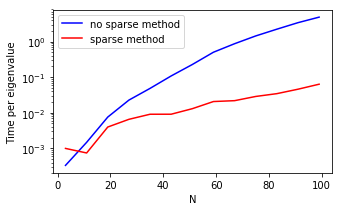

In [120]:
fig = plt.subplots(figsize=(5,3))
plt.plot(all_N, times_nosparse, label='no sparse method', color='blue')
plt.plot(all_N, times_sparse, label='sparse method', color='red')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('Time per eigenvalue')
plt.legend()
plt.savefig('eigenval_times.pdf', bbox_inches='tight')
plt.show()